# 00 - Problem Setup, Definitions, and Exploratory Analysis
---

## 1. Context and Motivation

Volatility forecasting plays a central role in financial economics and practice. Accurate assessments of future volatility are critical for risk management, derivative pricing, portfolio allocation, and regulatory capital calculations. Despite decades of research, daily volatility forecasting remains a challenging problem due to noise, nonstationarity, and abrupt changes in market conditions.

A key empirical observation is that volatility dynamics differ markedly across market environments. Calm periods exhibit slow-moving, persistent volatility, while turbulent periods are characterized by sharp spikes, rapid transitions, and elevated uncertainty. As a result, model performance cannot be fully understood through aggregate accuracy metrics alone. Understanding how different model classes behave across regimes is often more informative than identifying a single winner.

Prior literature comparing econometric and neural approaches to volatility forecasting reports mixed and unstable results (Sahiner et al., 2023; Kilic, 2025). Performance rankings depend strongly on sample period, asset class, target construction, and evaluation methodology. These findings motivate a diagnostic, behavior-focused analysis rather than a leaderboard-style comparison.

### Research Question

**How do structural and neural models differ in their ability to forecast daily realized volatility across market regimes?**

---

## 2. Object of Interest and Scope

### 2.1 Returns, Variance, and Volatility

Let $P_t$ denote the price at time $t$. The **log return** is defined as:

$$
r_t = \log(P_t) - \log(P_{t-1})
$$

The fundamental object of interest in this project is **daily conditional variance**:

$$
\sigma^2_t = \text{Var}(r_t \mid \mathcal{F}_{t-1}) = \mathbb{E}[r^2_t \mid \mathcal{F}_{t-1}]
$$

where $\mathcal{F}_{t-1}$ represents all information available up to time $t-1$. This assumes $\mathbb{E}[r_t \mid \mathcal{F}_{t-1}] = 0$, which is standard for daily returns.

### 2.2 Why Variance, Not Volatility?

Variance is the canonical target in GARCH-style models and allows direct comparison between econometric and neural approaches. Volatility (the square root of variance, $\sigma_t$) can be derived if needed, but variance is the natural scale for this analysis.

### 2.3 Latent Nature of Daily Variance

Daily conditional variance $\sigma^2_t$ is a **latent quantity**. It is defined as a conditional expectation and cannot be observed directly in realized market data. Consequently, volatility forecasts must be evaluated against an empirical proxy constructed from observed prices or returns. This introduces unavoidable measurement error into any evaluation of forecasting performance.

Throughout this project, conditional variance is treated as the latent target, while observable volatility measures are used solely as proxies for evaluation. More precisely, $RV_t$ estimates the variance that was realized on day $t$, while $\sigma^2_t$ represents the expectation of that realization formed at end of day $t-1$.

---

## 3. What This Project Does and Does Not Claim

To set appropriate expectations, we clarify the scope and limitations of this analysis:

### What This Project Does

- Compares behavioral differences between structural and neural volatility models
- Emphasizes regime-conditional diagnostics over aggregate accuracy metrics
- Treats daily volatility forecasting as an inherently noisy prediction task
- Focuses on understanding model behavior under different market conditions

### What This Project Does Not Claim

- No model is treated as ground truth
- No assumption of neural model superiority
- No expectation of unusually high explanatory power
- No attempt to declare a universal best model across regimes

Typical out-of-sample $R^2$ values for daily realized volatility forecasting lie in the range of approximately 0.30 to 0.50. Performance outside this range should not be expected given the noise inherent in volatility measurement.

---

## 4. Measuring Volatility in Practice

### 4.1 Squared Returns as a Naive Proxy

The simplest proxy for daily variance is the squared return $r^2_t$. Under the assumption of zero conditional mean,

$$
\mathbb{E}[r^2_t \mid \mathcal{F}_{t-1}] = \sigma^2_t
$$

Although unbiased in expectation, squared returns are extremely noisy because they rely on a single observation per day. As a result, they provide a poor signal for evaluating volatility forecasts, especially in comparative studies.

### 4.2 High-Frequency Realized Volatility

A more sophisticated approach constructs volatility measures from **intraday high-frequency data**. By observing prices at 5-minute or 10-minute intervals throughout the trading day, we can compute:

$$
\text{RV}_t = \sum_{i=1}^{M} r_{t,i}^2
$$

where $r_{t,i}$ are intraday returns within day $t$, and $M$ is the number of intraday observations.

**Why this is better**: By averaging many intraday squared returns, realized volatility measures smooth out much of the idiosyncratic noise $\epsilon_t$, providing a more stable estimate of $\sigma^2_t$.

> **Note on terminology:**  
> Although referred to as realized volatility by convention, the RV measures used here estimate integrated variance and therefore reside on the variance scale. Volatility in the usual sense corresponds to the square root of RV.

### 4.3 Realized Volatility Estimators

The **Oxford-Man Institute Realized Library** provides multiple RV estimators, each with different properties:

1. **rv5**: Realized volatility from 5-minute returns
   - Most commonly used in academic research
   - Balances noise reduction with market microstructure effects
   
2. **rv10**: Realized volatility from 10-minute returns
   - Less affected by microstructure noise (bid-ask bounce, etc.)
   - Fewer intraday observations per day
   
3. **medrv**: Median-based realized volatility
   - Robust to outliers and jumps
   - Less sensitive to extreme intraday moves

### 4.4 Choice of Primary Target: rv5

The primary evaluation target in this project is **rv5** for three reasons:

- Standard benchmark in academic volatility literature
- Optimal balance between noise reduction and microstructure robustness
- Direct comparability with prior research

Alternative realized volatility estimators (rv10, medrv) are used later as robustness checks rather than as separate optimization targets.

---

## 5. Why Daily Volatility Forecasting is Difficult

Even with high-quality realized volatility measures, daily volatility forecasting remains challenging. 

Key sources of difficulty include:

- Measurement error in volatility proxies
- Heavy-tailed and skewed volatility distributions
- Strong persistence combined with mean reversion
- Structural breaks and regime shifts

Volatility persistence leads to clustering, while mean reversion prevents shocks from persisting indefinitely. Effective forecasting models must balance responsiveness to sudden spikes with eventual decay toward a long-run level. This trade-off underlies many of the behavioral differences observed between structural and neural models.

---

## 6. Data Description

### 6.1 Asset and Market

- **Index**: S&P 500 (.SPX)
- **Data type**: Daily realized volatility and closing prices
- **Source**: Oxford-Man Institute Realized Library

### 6.2 Time Period

- **Start date**: January 3, 2000
- **End date**: December 31, 2019

This 20-year period captures multiple market regimes:
- Dot-com crash (2000-2002)
- Mid-2000s calm period (2003-2007)
- Financial crisis (2008-2009)
- Post-crisis recovery and expansion (2010-2019)

---   

## 7. Exploratory Analysis: Returns

Imports and Setup

In [1]:
# Standard library
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

# Project modules
PROJECT_ROOT = Path("..").resolve()
sys.path.insert(0, str(PROJECT_ROOT))

from src.data.rv_utils import (
    load_oxford_man_rv,
    extract_rv_series,
    compute_returns_from_prices,
    validate_rv_data,
    print_validation_report
)

from src.utils.rv_plotting import (
    plot_return_diagnostics,
    plot_rv_distribution,
    plot_acf_comparison,
    plot_rolling_statistics,
    plot_rv_squared_returns_comparison
)

from src.utils.io import ensure_dir
from src.utils.plotting import set_mpl_defaults

# Configuration
set_mpl_defaults()
np.random.seed(42)

# Paths
DATA_RAW = Path("../data/raw")
DATA_PROCESSED = ensure_dir(Path("../data/processed"))
FIG_DIR = ensure_dir(Path("../results/figures/eda"))

print("Setup complete!")

Setup complete!


Load and Validate Data

In [2]:
# Load Oxford-Man RV data
rv_filepath = DATA_RAW / "oxford_man_rv.csv"

data = load_oxford_man_rv(
    filepath=rv_filepath,
    symbol=".SPX",
    start_date="2000-01-01",
    end_date="2019-12-31"
)

print(f"Loaded {len(data)} observations")
print(f"Date range: {data.index.min()} to {data.index.max()}")
print("\nFirst few rows:")
display(data.head())

# Validate data quality
validation_report = validate_rv_data(data)
print_validation_report(validation_report)

Loaded 5017 observations
Date range: 2000-01-03 00:00:00 to 2019-12-31 00:00:00

First few rows:


,Symbol,open_to_close,rsv,medrv,rsv_ss,nobs,rv5,close_price,rv10,open_price
date,,,,,,,,,,
2000-01-03,.SPX,-0.011602,0.000096,0.000058,0.000096,1554,0.000141,1454.24,0.000164,1471.21
2000-01-04,.SPX,-0.035102,0.000180,0.000067,0.000180,1564,0.000224,1399.02,0.000295,1449.00
2000-01-05,.SPX,0.004625,0.000131,0.000142,0.000131,1552,0.000314,1402.09,0.000267,1395.62
2000-01-06,.SPX,0.002991,0.000056,0.000070,0.000056,1561,0.000131,1403.06,0.000115,1398.87
2000-01-07,.SPX,0.026293,0.000023,0.000049,0.000023,1540,0.000094,1440.84,0.000121,1403.45



REALIZED VOLATILITY DATA VALIDATION REPORT
Rows: 5,017
Date range: 2000-01-03 00:00:00 to 2019-12-31 00:00:00

WARNINGS:
  - 157 date gaps > 3 days detected



### 7.1 Return Distribution Properties

In [3]:
# Extract RV and price series
df = extract_rv_series(data, rv_col='rv5', price_col='close_price')

# Compute returns
df['return'] = compute_returns_from_prices(df['price'])
df['squared_return'] = df['return'] ** 2

# Drop first row (NaN from differencing)
df = df.dropna(subset=['return'])

print(f"After preprocessing: {len(df)} observations")
print("\nSummary statistics:")
display(df[['return', 'rv', 'squared_return']].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

# Save processed data
df.to_csv(DATA_PROCESSED / "returns_and_rv.csv")
print(f"\nSaved to: {DATA_PROCESSED / 'returns_and_rv.csv'}")


After preprocessing: 5016 observations

Summary statistics:


,return,rv,squared_return
count,5016.000000,5016.000000,5.016000e+03
mean,0.000159,0.000105,1.396850e-04
std,0.011819,0.000240,4.468599e-04
min,-0.096884,0.000001,0.000000e+00
1%,-0.034022,0.000005,4.720026e-09
5%,-0.018757,0.000008,1.345171e-07
50%,0.000542,0.000047,2.714347e-05
95%,0.016707,0.000345,5.689081e-04
99%,0.034034,0.001063,1.778261e-03
max,0.106420,0.007748,1.132527e-02



Saved to: ..\data\processed\returns_and_rv.csv


The summary statistics confirm key empirical regularities:

**Returns** ($r_t$):
- Mean daily return is effectively zero (≈ 0.016%), consistent with the absence of predictable drift.
- Daily return volatility is approximately 1.18%, corresponding to roughly 18-19% annualized volatility under square-root-of-time scaling.
- Extreme observations are substantial: minimum return ≈ −9.7%, maximum return ≈ +10.6%.
- Tail asymmetry is evident: the 1st percentile (≈ −3.4%) is more extreme than the 99th percentile (≈ +3.4%), indicating heavier downside tails.

These properties indicate **strong leptokurtosis and mild negative skewness**, both of which challenge models that assume Gaussian return innovations.

### 7.2 Visualize Return Diagnostics

The following diagnostics illustrate the distributional properties of daily log returns.

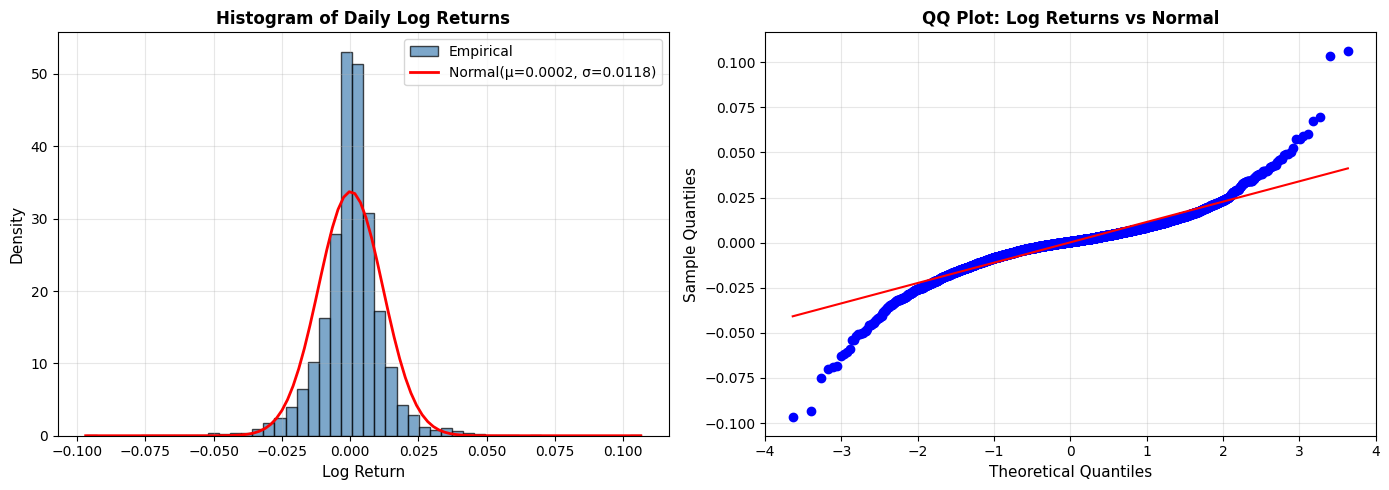

In [4]:
# Plot return distribution diagnostics
fig = plot_return_diagnostics(
    returns=df['return'],
    figsize=(14, 5),
    save_path=FIG_DIR / "return_distribution_diagnostics.png"
)
plt.show()


### Interpretation:

**Histogram with Normal Overlay:**
- The empirical distribution exhibits a sharper central peak than the Gaussian benchmark, indicating a high concentration of small daily returns.
- Both tails extend well beyond normal predictions, confirming fat-tailed behavior.

**QQ-Plot:**
- The central region follows the normal reference line closely, suggesting near-Gaussian behavior for moderate return realizations.
- The left tail deviates strongly below the diagonal, indicating more severe crash events than implied by normality.
- The right tail also deviates above the diagonal, though less dramatically than the left tail.

These diagnostics confirm that departures from normality are driven primarily by extreme events rather than typical daily fluctuations.

### 7.3 Implications for Modeling

1. **Fat tails validate heteroskedastic modeling**: GARCH's conditional variance framework is justified because returns clearly exhibit time-varying volatility with extreme events
2. **Leptokurtosis challenges MSE optimization**: Neural models trained with standard MSE loss will struggle to handle these tail events without robust transformations (e.g., log-variance targets)

---

## 8. Exploratory Analysis: Realized Volatility

### 8.1 Distribution of Realized Volatility

We now examine the distribution of realized volatility on both linear and logarithmic scales.

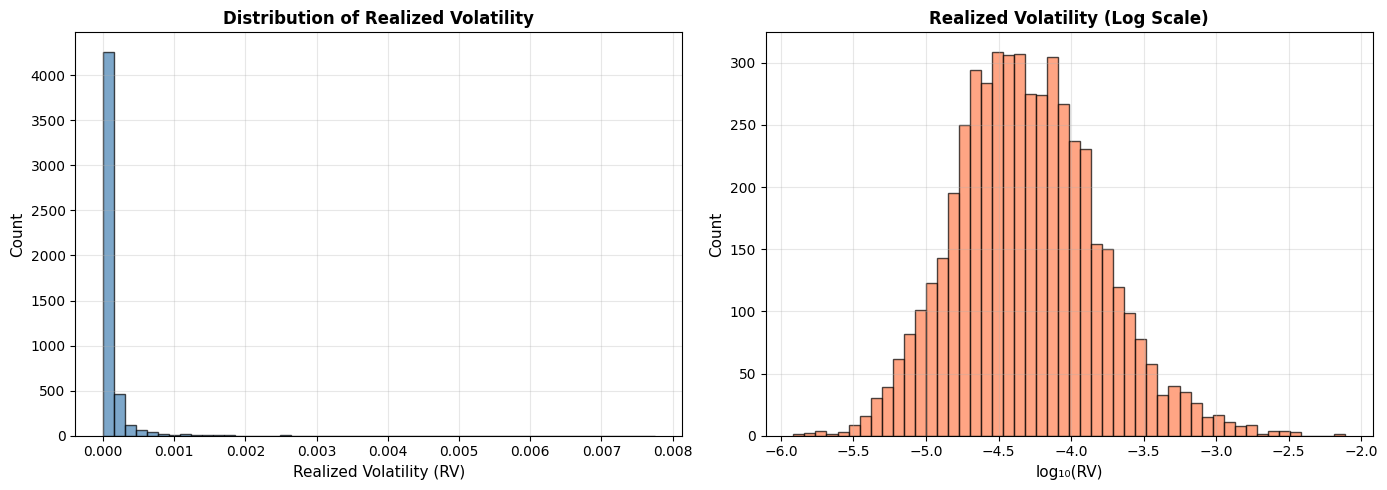

In [5]:
# Plot RV distribution (linear and log scale)
fig = plot_rv_distribution(
    rv=df['rv'],
    figsize=(14, 5),
    save_path=FIG_DIR / "rv_distribution.png"
)
plt.show()

### 8.2 Interpretation: Why RV Distribution Differs from Returns

**Linear scale:**
- The distribution is extremely concentrated near zero, with a long and sparse right tail.
- The median realized volatility (≈ 4.7e−05) is substantially smaller than the mean (≈ 1.05e−04), reflecting strong right skewness.

**Log scale:**
- The log-transformed distribution reveals structure spanning roughly three orders of magnitude.
- The majority of observations lie between 1e−05 and 5e−04, corresponding to low-to-moderate volatility days.
- Extreme observations above 1e−03 are rare but economically significant, corresponding to crisis and stress periods.

These properties highlight that realized volatility is fundamentally asymmetric and dominated by infrequent but extreme spikes.

### 8.3 Practical Consequences

1. **Signal extraction is sparse**: The variance signal must be inferred from observations that vary by 3-4 orders of magnitude
2. **Optimization instability**: Gradient-based training objectives can be dominated by rare spike days unless appropriate transformations or robust losses are used
3. **Structural alignment**: The strong persistence and mean-reverting behavior of realized volatility motivates models that encode temporal aggregation or autoregressive structure
4. **Forecasting limits**: Even with high-quality realized volatility measures, forecasting performance is constrained by irreducible noise in volatility dynamics


### 8.4 RV vs Squared Returns: Why RV is Superior

The following plots compare realized volatility with squared returns as alternative proxies for daily variance.

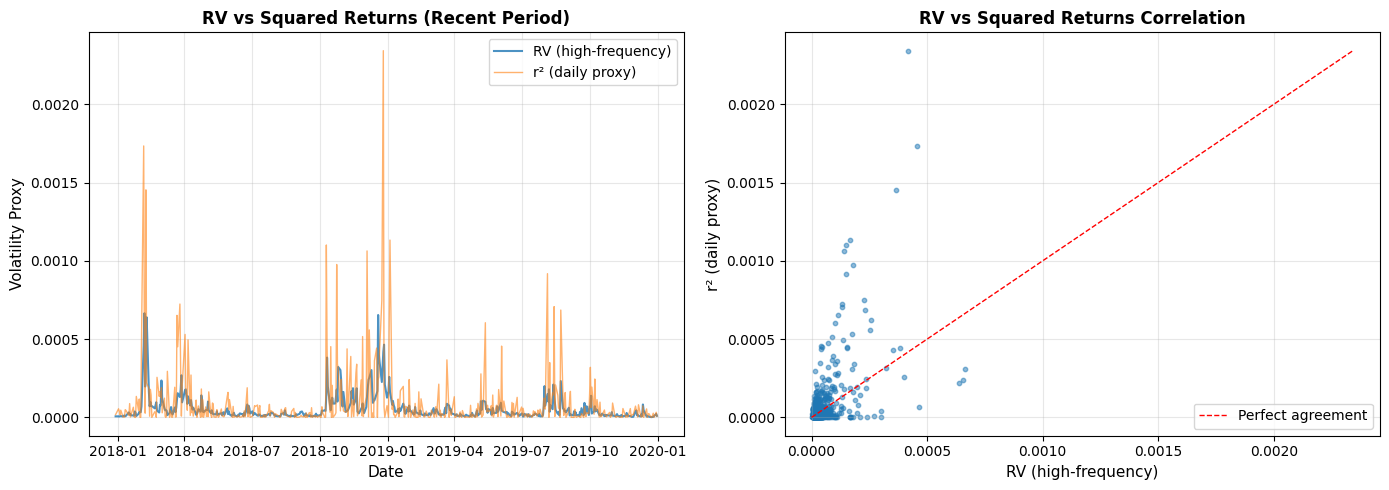

Correlation between RV and squared returns: 0.531


In [6]:
# Compare RV with squared returns
fig = plot_rv_squared_returns_comparison(
    rv=df['rv'],
    squared_returns=df['squared_return'],
    sample_size=500,
    figsize=(14, 5),
    save_path=FIG_DIR / "rv_vs_squared_returns.png"
)
plt.show()

# Compute correlation
corr = df[['rv', 'squared_return']].corr().iloc[0, 1]
print(f"Correlation between RV and squared returns: {corr:.3f}")

### Interpretation:

**Time series comparison:**
- Realized volatility exhibits smoother dynamics with clear clustering and persistence.
- Squared returns are extremely jagged, with frequent near-zero values punctuated by rare, extreme spikes.

**Scatter plot:**
- The correlation between realized volatility and squared returns is approximately 0.53.
- Despite positive association, dispersion is substantial, indicating large measurement error in squared returns.
- Squared returns frequently overshoot or undershoot realized volatility, particularly during extreme days.

This dispersion highlights the substantial measurement error in squared returns as a day-level variance proxy.

---

## 9. Volatility Clustering: The Core Stylized Fact

Volatility clustering is the empirical observation that **large moves tend to follow large moves, and small moves follow small moves**. This manifests as:

1. **Weak return autocorrelation**: Returns $r_t$ show minimal serial correlation (market efficiency)
2. **Strong RV autocorrelation**: Realized volatility $\text{RV}_t$ exhibits significant persistence over 10-20 lags

**Why this pattern matters**:
- It justifies **autoregressive variance models** that explicitly encode persistence
- It motivates **multi-horizon representations** of volatility dynamics

### 9.1 Time Series Evidence of Clustering

The following time series plots illustrate the temporal evolution of daily returns and realized volatility.

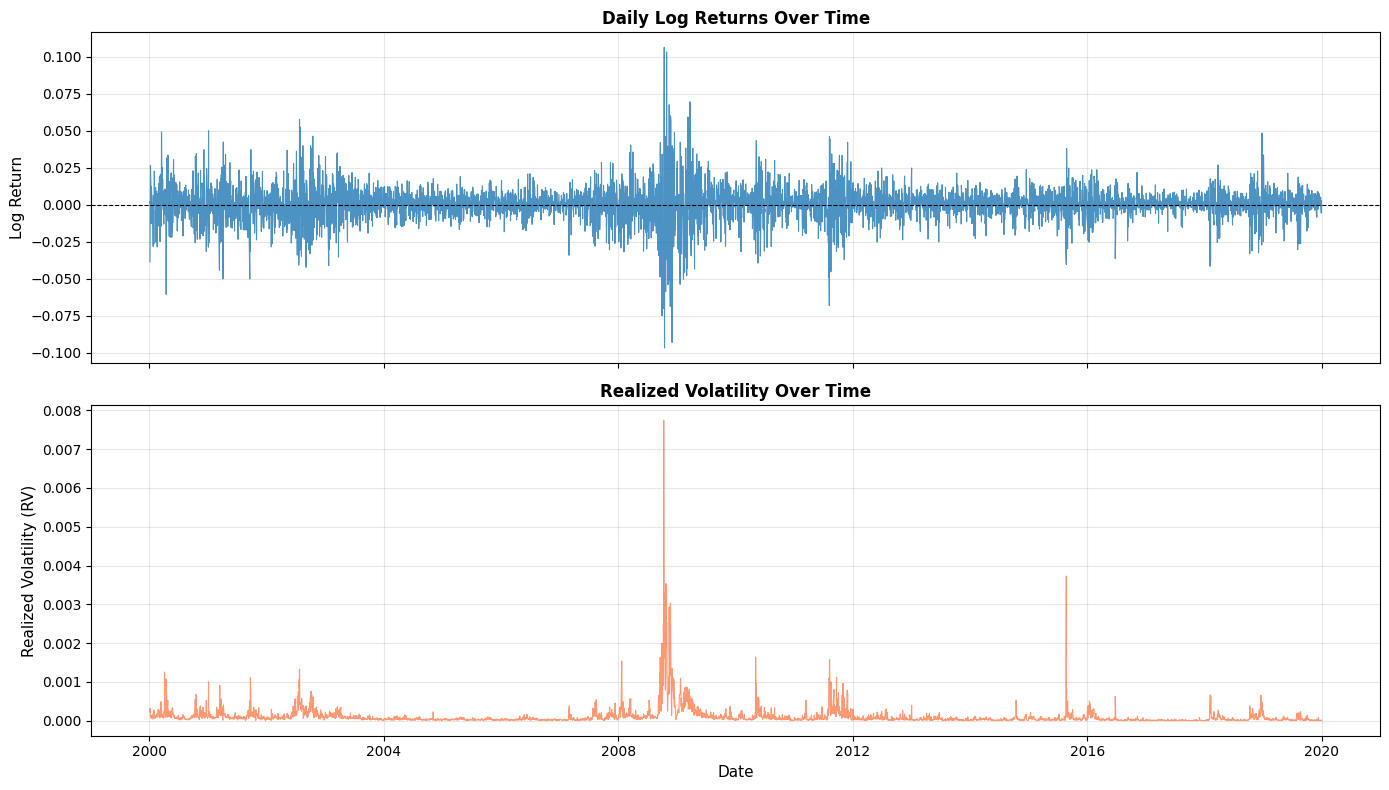

In [7]:
# Plot returns and RV over time
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Returns
axes[0].plot(df.index, df['return'], linewidth=0.8, alpha=0.8)
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[0].set_ylabel('Log Return', fontsize=11)
axes[0].set_title('Daily Log Returns Over Time', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Realized volatility
axes[1].plot(df.index, df['rv'], linewidth=0.8, alpha=0.8, color='coral')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Realized Volatility (RV)', fontsize=11)
axes[1].set_title('Realized Volatility Over Time', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / "ts_returns_and_rv.png", dpi=300, bbox_inches='tight')
plt.show()

Autocorrelation functions quantify the degree of serial dependence in returns and realized volatility.

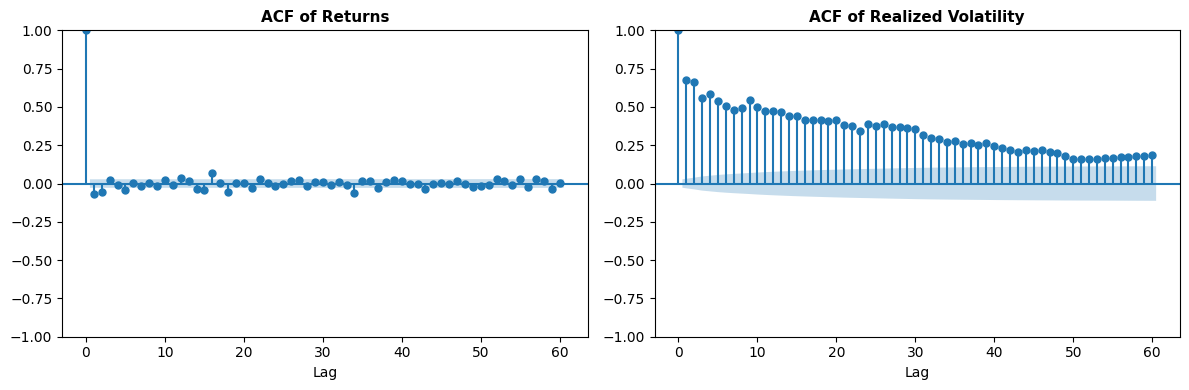

In [8]:
# Plot ACF for returns and RV
fig = plot_acf_comparison(
    data=df,
    cols=['return', 'rv'],
    titles=['ACF of Returns', 'ACF of Realized Volatility'],
    lags=60,
    figsize=(12, 4),
    save_path=FIG_DIR / "acf_returns_and_rv.png"
)
plt.show()

### Interpretation:

**Time series patterns**:
- **Returns** ($r_t$): Oscillate randomly around zero with occasional large spikes (2000-2002 dot-com, 2008-2009 financial crisis). No apparent serial dependence.
- **Realized volatility** (RV): Shows clear **clustering** - spikes are followed by periods of sustained elevated volatility (e.g., 2008-2009), while calm periods remain calm for extended stretches.

**Autocorrelation confirms clustering**:
- **Returns ACF** (left): Near-zero autocorrelation at all lags, consistent with market efficiency.
- **RV ACF** (right): Strong positive autocorrelation at short lags- indicates elevated variance persists over subsequent days. Gradual decay is consistent with long-memory behavior.

These persistence patterns establish volatility clustering as the dominant stylized fact governing daily variance dynamics.

---

## 10. Visual Intuition for Regime Dynamics

We do not define formal regime labels in this notebook. That is deferred to **Notebook 01**, where we ensure **no look-ahead bias** in regime definition. However, we visualize **rolling averages** of realized volatility to provide intuition for why regime-conditional evaluation matters.

The following visualization provides qualitative intuition for slow-moving volatility regimes and abrupt transitions between them.

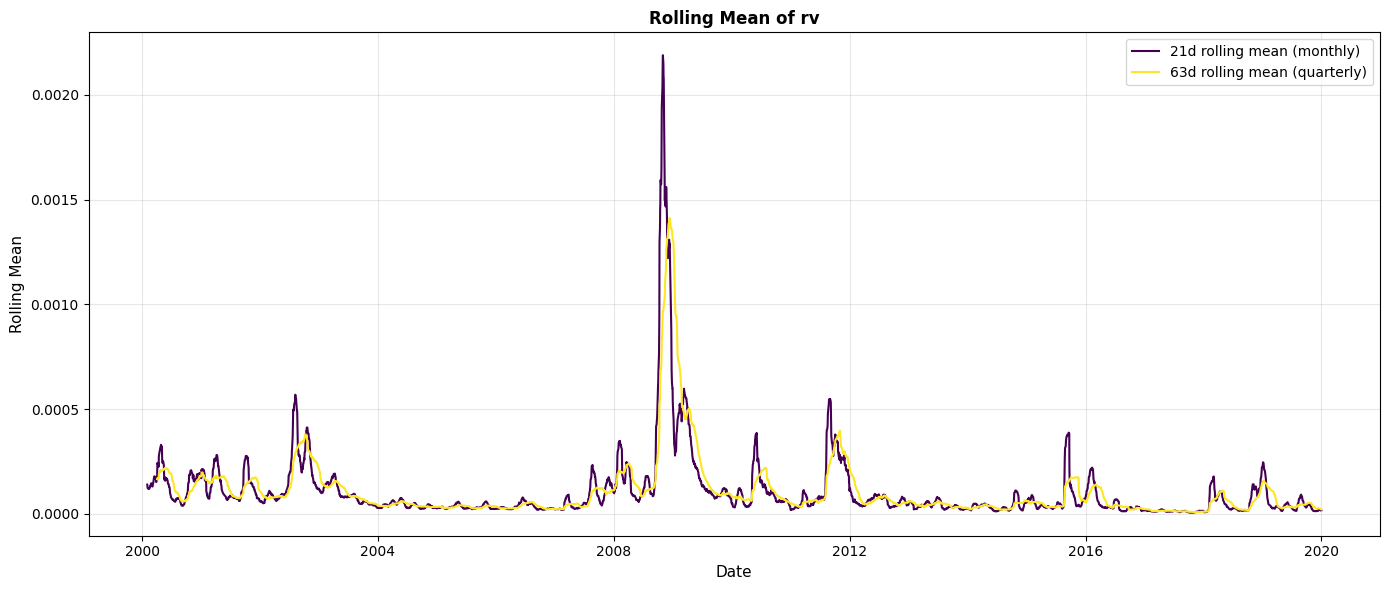

In [9]:
# Compute rolling means at multiple horizons
df['rv_roll_21'] = df['rv'].rolling(21).mean()  # ~1 month
df['rv_roll_63'] = df['rv'].rolling(63).mean()  # ~1 quarter

# Plot rolling statistics
fig = plot_rolling_statistics(
    series=df['rv'],
    windows=[21, 63],
    stat='mean',
    labels=['21d rolling mean (monthly)', '63d rolling mean (quarterly)'],
    figsize=(14, 6),
    save_path=FIG_DIR / "rolling_mean_rv.png"
)
plt.show()

### Interpretation:

The plot shows:
- **Calm periods**: Low, stable rolling RV (e.g., 2003-2007, 2013-2019)
- **Turbulent periods**: Elevated, volatile rolling RV (e.g., 2000-2002, 2008-2009, 2010-2011)
- **Transitions**: Sharp regime shifts often coincide with market crises

This visualization provides intuition for why volatility regimes are a meaningful organizing principle, without imposing formal regime definitions.

---

## 11. Implications for Model Comparison

The empirical findings from Sections 7-10 motivate a shift from aggregate accuracy metrics toward behaviorally informative diagnostics.

This exploratory analysis reveals key facts that shape our modeling approach and evaluation framework:

### 11.1 Why Aggregate Metrics Can Be Misleading

- **Regime mixing**: A model with RMSE = 0.0005 could have RMSE = 0.0003 in calm periods and RMSE = 0.001 in turbulent periods, or vice versa
- **Different error patterns**: Model A might underpredict spikes but track calm periods well; Model B might overpredict calm periods but capture spikes accurately
- **Hidden trade-offs**: Better aggregate performance may come at the cost of worse tail-event forecasting or excessive forecast volatility

### 11.2 Why Regime-Conditional Evaluation is Necessary

Given the clear alternation between calm and turbulent regimes observed in the rolling statistics:
- **Structural models** (HAR, GARCH) encode different assumptions about persistence and mean reversion
- **Neural models** learn patterns from data without explicit structural constraints
- **Performance likely varies** across regimes based on how well each model class handles:
  - Persistence during calm periods
  - Rapid adjustment during volatility spikes
  - Smooth transitions between regimes

### 11.3 Preview of Behavioral Diagnostics

Rather than relying solely on RMSE or MAE, we will evaluate models using:

1. **Spike response time**: How quickly do forecasts react to volatility spikes?
2. **Forecast smoothness**: Do forecasts exhibit excessive volatility or inappropriate stability?
3. **Regime-transition error**: How accurate are forecasts immediately after regime shifts?
4. **Error distribution skewness**: Do models systematically over- or under-predict in different regimes?

These diagnostics reveal **how models fail**, not just **how much they fail**, providing actionable insights for model selection and combination.

---

## 12. Summary

This notebook established the empirical and conceptual foundations for daily volatility forecasting.

Key findings include:
- Daily returns are weakly predictable and exhibit heavy tails.
- Realized volatility provides a substantially cleaner proxy for latent variance than squared returns.
- Volatility dynamics are persistent, mean-reverting, and regime-dependent.
- Aggregate accuracy metrics obscure meaningful differences in model behavior across market conditions.

These observations motivate a regime-aware evaluation framework. The next notebook formalizes volatility regimes in a statistically defensible manner without look-ahead bias.

---